# Drivable Area Detection

In this notebook we will train a model to segment the drivable area of a road scene. To do this we will use transfer learning and leverage a pretrained torchvision model.

# <a name="Data"></a>1. Data Collect, Visualization, Augmentation

This project will use the [BDD 100K Dataset](https://bdd-data.berkeley.edu/).<p>

It was downloaded from [this website](https://bdd-data.berkeley.edu/login.html)

If you want to repeat the process, go to the [download page](https://bdd-data.berkeley.edu/portal.html#download) (once logged in) and click on the buttons **Images** and **Driverable Maps** under the BDD100K section.
It will download the necessary dataset. Then pick a subset of it.
Use Google Chrome and in case it doesn't work, hit the button again until it does.<p>-<p>

The data has already been downloaded and preprocessed to contains 2 categories for segmentation:
- drivable area (red)
- adjacent area (blue)
- background (green)

See preprocess_data.py for details on how to do this with the raw data.

The data has been placed in the following folder structure:

Data--<br>
&emsp;&emsp; train- <br>
&emsp;&emsp;&emsp;&emsp;  images <br>
&emsp;&emsp;&emsp;&emsp;  mask <br>
&emsp;&emsp; val- <br>
&emsp;&emsp;&emsp;&emsp;  images <br>
&emsp;&emsp;&emsp;&emsp; mask <br>
&emsp;&emsp; test- <br>
&emsp;&emsp;&emsp;&emsp;  images <br>
&emsp;&emsp;&emsp;&emsp; mask <br>

We have defined a Custom Dataset class in segmentation_loader.py to handle our data

**Base Library Imports**

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

## Create the DataLoader

In the dataloader section we will define the batch size and how much we will downsample the image. We will train on the same image size for every epoch and mini batch, since we are only training with less than 3000 images.

The dataloader will automatiaclly add color jitter and shadow augmentations if 'extra_transforms' is set to True. The dataloader also normalizes all images if 'normalize' is set to True.

In [75]:
from torchvision import transforms
from torch.utils.data import DataLoader
from segmentation_loader import RandomShadowTransform, SegmentationDataset, mask2cat, cat2mask

OG_W, OG_H = (720, 1280)
W, H = (360, 640) # 2x downsize
BATCH_SIZE = 4

# images are always normalized in the Dataset class
train_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((W, H)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip()
                                ])

# for validation and test loader (need to normalize for pipeline)
valid_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((W, H)),
                                ])

# for implementing segmentation pipeline 
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((W, H)),
                                transforms.Normalize(
                                    [0.485, 0.456, 0.406], 
                                    [0.229, 0.224, 0.225])
                                ])

datapath = r'C:\Users\itber\Documents\datasets\segmentation\drivable_area_dataset'
train_dataset = SegmentationDataset(os.path.join(datapath, 'train'), train_transforms) 
valid_dataset = SegmentationDataset(os.path.join(datapath, 'val'), valid_transforms,
                                    extra_transforms=False) 
test_dataset = SegmentationDataset(os.path.join(datapath, 'test'), valid_transforms, 
                                   extra_transforms=False) 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Test Dataloader

In [3]:
def convert_image(image):
    ''' converts normalized tensor float image to 
        unnormalized numpy uint8 array
        '''
    image = image.detach().cpu().numpy().transpose(1, 2, 0) # convert to numpy
    image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406] # undo normalizarion
    image = (np.clip(image, 0, 1)*255).astype(np.uint8) # convert to uint8

    return image

def convert_mask(mask):
    ''' converts mask from float tensor to numpy uint8 array '''
    mask = (mask.detach().cpu().numpy()).astype(np.uint8)
        
    return mask

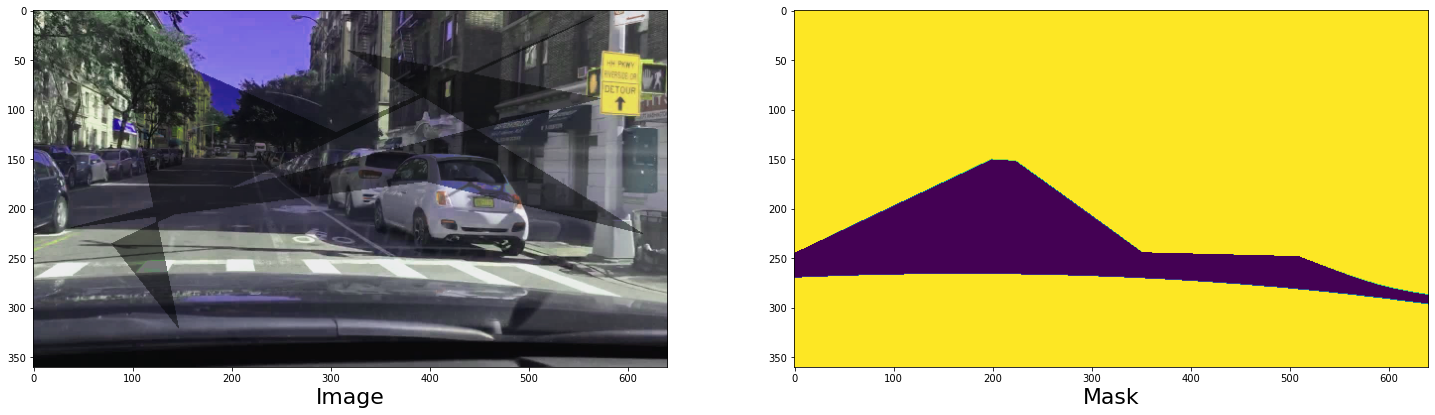

In [4]:
imgs = next(iter(train_loader))

image = convert_image(imgs[0][0])
mask = convert_mask(imgs[1][0])

_, ax = plt.subplots(1, 2, figsize=(25, 15))
ax[0].imshow(image)
ax[0].set_xlabel('Image', size=22)
ax[1].imshow(mask)
ax[1].set_xlabel('Mask', size=22);

#### Convert the Categoral Mask back to an RGB Image

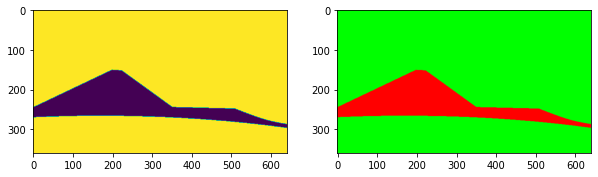

In [5]:
# convert the categoral image back to an RGB color mask
mask_out = cat2mask(mask) 

_, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(mask)
ax[1].imshow(mask_out);

### Overlay the mask on the image
Create the image that we want the model to ultimatley produce: The mask overlaid on the image

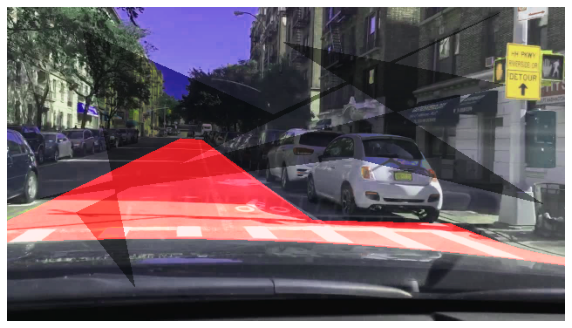

In [6]:
import cv2

# remove background for display
mask_out[:, :, 1] = 1

# need to use opencv to get color masks

def mask_image(image, mask):
    masked = cv2.addWeighted(image, 1, mask, 0.75, 0.)
    return masked

masked = mask_image(image, mask_out)
fig = plt.figure(figsize=(10, 8))
plt.imshow(masked);
plt.axis('off');

# <a name="Model"></a>2. Create A Deep Learning Model


## Model Definition

Here we will use the pre trained [DeepLab](https://arxiv.org/pdf/1606.00915.pdf) model from torchvision. When training this model we will experiment with the [Categorical Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) Loss function and the [Dice](https://kornia.readthedocs.io/en/v0.1.2/_modules/torchgeometry/losses/dice.html) Loss function. We will see how the choice of loss function can influence the trained model. 

Initially experiments were done where only the classifier of deeplabv3 was trained while the backbone was frozen. The other experiments involved unfreezing the entire model. In this experiment unfreezing the entire model had significantly better results than finetuning the classifier.





In [7]:
import torchvision

model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)


In [8]:
# display all layers in the model
for name, child in model.named_children():
    print(name)



backbone
classifier
aux_classifier


Change final layer to output 3 classes

In [9]:
model.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))

Explicitly freeze all layers and unfreeze the classifier

In [10]:
def unfreeze_layers(model, layers):
    ''' unfreezes any layer contained in layers '''

    for name, child in model.named_children():
        if name in layers:
            print(f'{name} has been unfrozen')
            for param in child.parameters():
                param.requires_grad = True

        else:
            # freeze remaining layers
            print(f'{name} has been frozen')
            for param in child.parameters():
                param.requires_grad = False

In [11]:
# explicitly freeze/unfreeze desired layers
# unfreeze_layers(model, ['classifier'])

In [12]:
# check for gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Define hyperparameters and loss function

In [13]:
import torch.nn as nn
import torchgeometry as tgm

# hyper parameters
LEARNING_RATE = 0.0001
EPOCHS = 15

# define loss weights
CE_W = 0.
DICE_W = 1.


# loss function
def criterion(pred, target):

    # NOTE: order matters for this loss function
    if DICE_W != 0:
        dice_loss = tgm.losses.DiceLoss()(pred, target.to(torch.long)) 
    else:
        dice_loss = 0.

    # reshape for cross entropy loss
    if CE_W != 0:
        cross_entropy_loss = \
            nn.CrossEntropyLoss()(
                pred.view(BATCH_SIZE, 3, -1), 
                target.view(BATCH_SIZE, -1).to(torch.long))
    else:
        cross_entropy_loss = 0    

    # get combined loss
    loss =  CE_W*cross_entropy_loss + DICE_W*dice_loss

    return loss

#### Define optimizer

In [14]:
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## MODEL TRAINING

In [15]:
# load model if needed
# model = torch.load(r'models\1.pth').to(device)

In [ ]:
import time 

# place model on device
model = model.to(device)

# store losses in lists
train_epoch_loss = []
valid_epoch_loss = []

for e in range(1, EPOCHS + 1):
    # train the model
    model.train()
    train_loss = []
    for i, (images, masks) in enumerate(train_loader):

        # move data to device
        images, masks = images.to(device), masks.to(device)

        # forward pass through model and get loss
        outputs = model(images)['out']
        
        # compute loss
        loss = criterion(outputs, masks)

        # reset optimizer 
        optimizer.zero_grad()

        # backpropagate the loss
        loss.backward()

        # update the weights
        optimizer.step()

        # update the loss
        train_loss.append(loss.item())
        # display the loss every 100 mini-batches
        if i % 99 == 0:
            print(f'Epoch: {e} -- Train Loss: {train_loss[-1]:.3f}')
            time.sleep(10) # cool down

    # validate the model
    model.eval()
    valid_loss = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(valid_loader):

            # move data to device
            images, masks = images.to(device), masks.to(device)

            # forward pass through model and get loss
            outputs = model(images)['out']
            
            # compute loss
            loss = criterion(outputs, masks)

            # update the loss
            valid_loss.append(loss.item())
            # display the loss every 100 mini-batches
            if i % 99 == 0:
                print(f'Epoch: {e} -- Valid Loss: {valid_loss[-1]:.3f}')
                time.sleep(5) # cool down

            # time.sleep(5) # cool down

    # get average train and valid loss for each epoch
    train_epoch_loss.append(np.mean(train_loss))
    valid_epoch_loss.append(np.mean(valid_loss))

    # save model every  epoch
    save_path = f'models\{e}.pth'
    torch.save(model, save_path)
    time.sleep(10) # cool down


**Plot Training Results**

In [ ]:
plt.plot(train_epoch_loss, label='train')
plt.plot(valid_epoch_loss, label='valid')
plt.title('loss per epoch')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [ ]:
print(np.round(train_epoch_loss, 3))
print(np.round(valid_epoch_loss, 3))

## Test the Model

In [58]:
# run test loop
model.eval()
test_loss = []
with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):

        # move data to device
        images, masks = images.to(device), masks.to(device)

        # forward pass through model and get loss
        outputs = model(images)['out']

        # compute loss
        loss = criterion(outputs, masks)
        
        # update the loss
        test_loss.append(loss.item())
        # display the loss every 100 mini-batches
        if i % 99 == 0:
            print(f'Test Loss: {test_loss[-1]:.3f}')

Test Loss: 0.054


In [59]:
np.mean(test_loss)

0.6841927786859182

#### Display outputs from the test data

In [12]:
# load model if needed
# model = torch.load(r'models\1.pth').to(device)

In [17]:
# do a sample pass on some data!
images, masks = next(iter(test_loader))

# move to device
images, masks = images.to(device), masks.to(device)
model = model.to(device)

# run a forward pass to test things out
outputs = model(images)['out']

In [18]:
# helper functions
def get_prediction_labels(outputs):
    ''' Requires a 4D tensor '''
    predictions = F.softmax(outputs, dim=1)
    pred_labels = torch.argmax(predictions, dim=1) # each pixel has it's own label ID
    
    return pred_labels

def get_resized_mask(mask_cat, og_size=(H, W)):
    mask_cat = mask_cat.detach().cpu().numpy()
    mask = cv2.resize(cat2mask(mask_cat), og_size)

    return mask

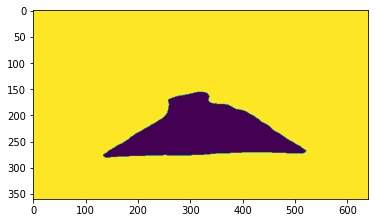

In [33]:
plt.imshow(pred_labels[0].detach().cpu().numpy())

In [43]:
# test helper functions and get prediction for a given test image
idx = 0

pred_labels = get_prediction_labels(outputs)
mask = get_resized_mask(masks[idx])
pred = get_resized_mask(pred_labels[idx])

img = cv2.resize(convert_image(images[idx]), (H, W))

# remove background and mask image
pred_copy = pred.copy()
pred_copy[:, :, 1] = 0
pred_masked = mask_image(img, pred_copy)

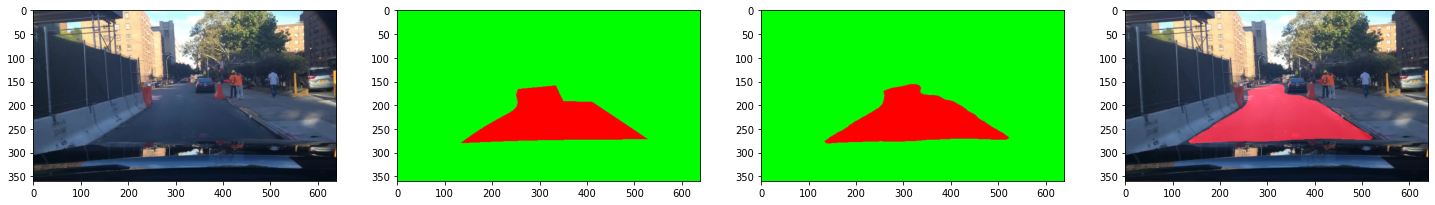

In [44]:
_, ax = plt.subplots(1, 4, figsize=(25, 10))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(pred)
ax[3].imshow(pred_masked);

## Build Drivable Road segmentation pipeline

In [76]:
def get_drivable_area_mask(image, transform, model):
    # get original image shape
    resize = image.shape[:2][1::-1]

    # transform image and place on device
    image = test_transforms(image).unsqueeze(0).to(device)
    model = model.to(device)

    # get model outputs
    output = model(image)['out']

    # get prediction labels
    pred_labels = get_prediction_labels(output)

    # get resized prediction mask
    pred_mask = get_resized_mask(pred_labels.squeeze(0), resize)

    # remove green background for display
    pred_mask[:, :, 1] = 0

    return pred_mask

def segment_drivable_area(image):
    pred_mask = get_drivable_area_mask(image, test_transforms, model)
    segmented = mask_image(image, pred_mask)
    
    return segmented

### Test pipeline on out of sample data 
In this case out of sample data is anything road scenario that did not come from the bdd100k dataset. Eventhough this dataset is diverse, we only had 3000 images to train, validate, and test with. This out of sample testing will give us a good idea of just how well the model can generalize.

Observed good models:
- unfrozen half dice: models 8 and 11
- unfrozen cross entropy: 2 and 12
- No models trained using the pure dice loss obtained good results

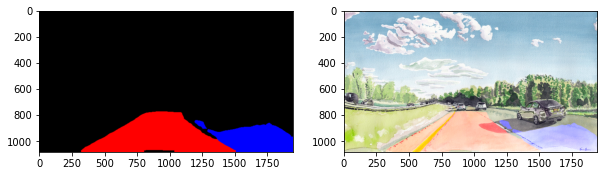

In [93]:
model = torch.load(r'models\unfrozen_half_dice\11.pth').to(device)
# model = torch.load(r'models\unfrozen_vanilla\12.pth').to(device)

# change name of base path and update drivable area Unet
base_path = r'C:\Users\itber\Documents\datasets\segmentation\out_of_sample'
image_path = os.path.join(base_path, 'watercolor.jpg')
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

pred_mask = get_drivable_area_mask(image, test_transforms, model)
segmented = segment_drivable_area(image)

_, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(pred_mask)
ax[1].imshow(segmented);


# <a name="Video"></a>3. Run on a Video

Here is the best part. FCN models generally are fast. They can run on CPU at 5 FPS and on GPU at a very high frame rate.<p>
Test your code on a video and see how it worked.

In [55]:
video_path = os.path.join(base_path, r'videos\project.avi')

video_frames = []

cap = cv2.VideoCapture(video_path)

while(cap.isOpened()):

    ret, frame = cap.read()

    if ret == True:

        # get frames from the video in RGB
        video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # exit if needed
        # if cv2.waitKey(1) == ord('q'):
        #    break

    else:
        break

cap.release()
# cv2.DestroyAllWindows
del cap

#### Segment images

In [56]:
from tqdm import tqdm

# model = torch.load(r'models\25.pth').to(device)
segmented_images = []

for image in tqdm(video_frames):
    segmented = segment_drivable_area(image)
    segmented_images.append(segmented)


100%|██████████| 305/305 [00:21<00:00, 14.28it/s]


In [96]:
len(segmented_images)

305

#### Check model performance in presence of shawdows
In project.avi there are several instances with shadows. The data has been augmented with random shadows to increase performance. 

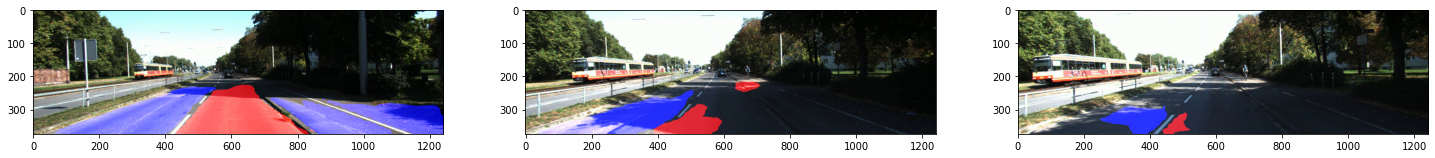

In [57]:
# Unfrozen Dice loss model
_, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(segmented_images[92])
ax[1].imshow(segmented_images[98])
ax[2].imshow(segmented_images[100]);

In [58]:
# save as a video
VIDEO_PATH = os.path.join(base_path, r'videos\project_unfrozen_dice_12.mp4')

height, width = image.shape[:2] # ensure image comes from desired video
height, width = height//2, width//2
video = cv2.VideoWriter(VIDEO_PATH, cv2.VideoWriter_fourcc(*'DIVX'), 
                        15, (width, height))

for seg_img in segmented_images:
    # convert back to BGR for opencv
    seg_img = cv2.cvtColor(seg_img, cv2.COLOR_RGB2BGR)
    video.write(cv2.resize(seg_img, (width, height), 
                           cv2.INTER_LANCZOS4))

# cv2.destroyAllWindows()
video.release()
del video

#### Try on the KITTIT dataset

In [100]:
from glob import glob
kitti_path = r'C:\Users\itber\Documents\datasets\KITTI\kitti_object_tracking_left_color\training\image_02\0020'

kitti_images = [cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB) 
                for im_path in glob(os.path.join(kitti_path, '*.png'))]


In [103]:
print(len(kitti_images))
print(kitti_images[0].shape)

837
(376, 1241, 3)


In [106]:
from tqdm import tqdm

model = torch.load(r'models\unfrozen_vanilla\12.pth').to(device)

segmented_images = []

for image in tqdm(kitti_images):
    segmented = segment_drivable_area(image)
    segmented_images.append(segmented)

100%|██████████| 837/837 [00:59<00:00, 14.15it/s]


In [107]:
# save as a video
VIDEO_PATH = os.path.join(base_path, r'videos\kitti_unfrozen_vanilla_12.mp4')

height, width = image.shape[:2] # ensure image comes from desired video
height, width = height//2, width//2
video = cv2.VideoWriter(VIDEO_PATH, cv2.VideoWriter_fourcc(*'DIVX'), 
                        15, (width, height))

for seg_img in segmented_images:
    # convert back to BGR for opencv
    seg_img = cv2.cvtColor(seg_img, cv2.COLOR_RGB2BGR)
    video.write(cv2.resize(seg_img, (width, height), 
                           cv2.INTER_LANCZOS4))

# cv2.destroyAllWindows()
video.release()
del video